# I&I: Apprentissage profond et traitement du signal

# TP3: Classification de modulation par deep learning

Eleve : Théo Di Piazza (MVA)

Date : Novembre 2022

In [ ]:
# Connect to google colab to save the script as HTML as the end of the execution
from google.colab import drive
drive.mount('/content/drive')

path_folder = '/content/drive/MyDrive/MVA/Cours/I&I_Signal'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import libraries
import numpy as np 
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import h5py 
import torch
import warnings

from matplotlib import pylab as plt 
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader

# Hide warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Notes sur les dimensions

Pour un signal de dimension N avec K channels.

- Dimension de sortie après une couche de convolution Nconv, Kconv, Stride, Padding : 

$$1+(N + 2*padding - Nconv)/stride$$

- Dimension de sortie après une couche de max pooling  Npool, padding, stride: 

$$1+(N + 2*padding - Npool)/stride$$

Par défaut, $stride = Npool$.

Notes : on préconise des Kernels impaires. Faire du padding pour éviter les effets de bords!

## Données

L'objectif de ce projet est à partir de l'observation de 1024 échantillons d'un signal IQ de retrouver la modulation qui l'a constitué parmi: 
- BPSK
- PSK8
- QAM16
- QAM32
- QAM64
- QAM8
- QPSK

A chaque modulation nous avons associé un nombre entier identifiant:
{'BPSK': 0,
 'PSK8': 1,
 'QAM16': 2,
 'QAM32': 3,
 'QAM64': 4,
 'QAM8': 5,
 'QPSK': 6}

## Format

Les données sont distribuées dans trois fichiers indépendants: 
- augmod_train.hdf5
- augmod_valid.hdf5
- augmod_test.hdf5 

L'ensemble de train est destiné à nourrir l'entraînement d'un réseau de neurones profond, l'ensemble de validation à monitorer l'évolution de métriques sur un ensemble indépendant durant un entraînement et l'ensemble de test est destiné à évaluer le modèle une fois entraîné. 

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.
Un groupe peut contenir plusieurs datasets. Un groupe contient aussi un champs .attrs qui permet de regrouper des informations sous forme de dictionnaire. 

Un fichier de données D contient: 
- un groupe 'labels' qui regroupe les correspondances nom_modulation -> id_modulation 
   - D['labels'].attrs[k] avec k dans D['labels'].attrs.keys() 
   - plus bas la fonction get_labels permet d'extraire ces correspondances sous forme d'un dictionnaire
- un dataset 'signal': D['signal'] qui est de dimensions [N,2,1024] et contient N signaux IQ de 1024 échantillons
- un dataset 'snr': D['snr'] qui est de dimension [N], la composante  i codant le rapport signal sur bruit (en dB) du signal D['signal'][i,:,:] 

Les cellules suivantes donne un exemple d'ouverture d'un des fichiers de données: 

### Fonction utilitaire

In [ ]:
def get_labels(open_h5_file): 
    return {
        open_h5_file['labels'].attrs[k] : k
        for k in open_h5_file['labels'].attrs.keys()
    }

### Conversion directe en numpy

In [ ]:
data_path = '/content/drive/MyDrive/MVA/Cours/I&I_Signal/augmod_train.hdf5'

data = h5py.File(data_path , 'r')

signals = np.array(data['signals'])
snr =  np.array(data['snr'])
labels_id = np.array(data['type'])

labels_dict = get_labels(data)

data.close()

Il y a 87360 signaux, de dimensions (2,)



Le SNR du signal 1001 est 40.0
Le signal 1001 a pour id 1 il est de type PSK8


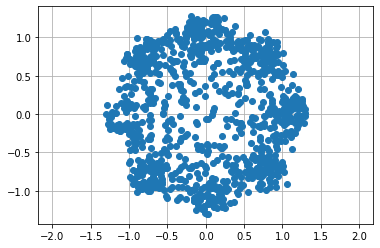

In [ ]:
print(f'Il y a {signals.shape[0]} signaux, de dimensions {signals.shape[1:2]}')
print('\n\n')

num_signal = 1001 

plt.figure()
print(f'Le SNR du signal {num_signal} est {snr[num_signal]}' )
print(f'Le signal {num_signal} a pour id {labels_id[num_signal]} il est de type {labels_dict[labels_id[num_signal]]}' )

plt.plot(signals[num_signal,0,:] , signals[num_signal,1,:],'o')
plt.axis('equal')
plt.grid()

### Utilisation des buffers hdf5 

Le SNR du signal 1001 est 40.0
Le signal 1001 a pour id 1 il est de type PSK8


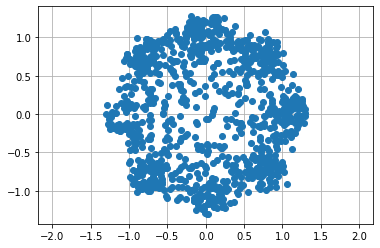

In [ ]:
data = h5py.File(data_path , 'r')

labels_dict = get_labels(data)


num_signal = 1001 

plt.figure()
print(f"Le SNR du signal {num_signal} est {data['snr'][num_signal]}" )
print(f'Le signal {num_signal} a pour id {labels_id[num_signal]} il est de type {labels_dict[labels_id[num_signal]]}' )

plt.plot(data['signals'][num_signal,0,:] , data['signals'][num_signal,1,:],'o')
plt.axis('equal')
plt.grid()


data.close()

## Objectifs du TP 

Pour ce TP vous devez 

1/ Visualiser les données d'entraînement, la distribution des types de modulations représentées dans l'ensemble de données et la distribution des SNR
2/ (optionnel) Proposer une méthode simple, 'baseline' pour l'identification de modulations
3/ Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
4/ Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html. 
5/ Qualifier les performances de votre réseau de neurones sur l'ensemble de test via: 
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR 
   - La réalisation des matrices de confusion entre les différentes classes pour un SNR de 10 dB (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation. 

---
## Sommaire du Notebook

### 1 - Visualisation de données

### 2 - Modèles & Entrainements (Modèle 1, 2 et 3).

### 3 - Test du modèle retenu

### 4 - Conclusion

## 1 - Visualisation de données

### 1.1 - Représentation d'un signal pour chaque label

Tout d'abord, on souhaite représenter un signal pour chaque label.

On créé donc une liste de longueurs 7 (car 7 labels) avec un indice associé à chaque label.

In [ ]:
# Find indices of signals for each label
indices_signal = []

# Représentation du signal
labels = [0, 1, 2, 3, 4, 5, 6]

# For each label
for lab in labels:
  # For each signal
  for i in range(len(signals)):
    # If the current label and the label of the current signal matches
    if(lab == labels_id)[i]:

      indices_signal.append(i) # Add index of the signal to the list

      break

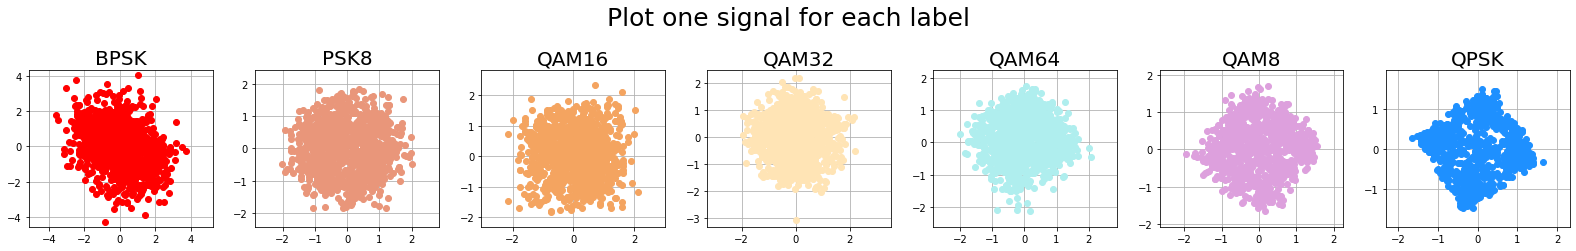

In [ ]:
dict_indToColor = {0:"red", 
                   1:"darksalmon",
                   2:"sandybrown",
                   3:"moccasin",
                   4:"paleturquoise",
                   5:"plum",
                   6:"dodgerblue"}

i = 1 # Index for subplot
for num_signal in indices_signal:

  plt.rcParams['figure.figsize'] = [22, 3] # Size of plot
  plt.subplot(1, 7, i) # Position
  plt.plot(signals[num_signal, 0, :], signals[num_signal, 1, :], 'o', color=dict_indToColor[i-1]) # Plot
  plt.axis('equal') 
  plt.grid()
  plt.title(f"{labels_dict[labels_id[num_signal]]}", size=20)

  i += 1

plt.suptitle(f"Plot one signal for each label", fontsize=25, y=1.15)
plt.tight_layout()
plt.show()

### 1.2 - Répartition des labels dans le jeu de données

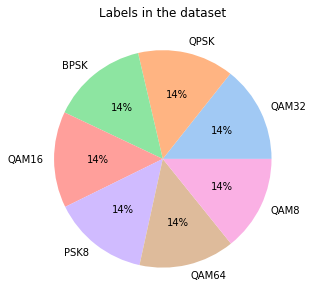

In [ ]:
# For each labels, compute % of occurences
labels_percentage = 100*pd.Series(labels_id).value_counts()/len(labels_id)

list_labels = [labels_dict[x]  for x in labels_percentage.index.tolist() ]
list_percentage = labels_percentage.values.tolist()

# Plot Pie-Chart of Percentage
fig = plt.figure(figsize=(5, 5)) # Size of plot
colors = sns.color_palette('pastel')[0:7] # Colors
plt.pie(list_percentage, labels = list_labels, colors = colors, autopct='%.0f%%')
plt.title("Labels in the dataset")
plt.show()

Le jeu de données d'entrainement est équilibré car chaque label représente 14% du jeu de donnée.

## 2 - Modèles

### 2.0.1 - DataLoaders

Fonctions pour obtenir des données.

In [ ]:
def get_dataloader(device, batch_size=64):
  '''
  Load train, validation and test sets
  Input:
    batch_size (int): Batch Size used in the network. default=64.
    device: environment execution (cuda, cpu...).
  Returns:
    train_loader, val_loader, test_loader: DataLoader of train, validation and test set
  '''
  # Paths of datasets
  train_path = '/content/drive/MyDrive/ENS_MVA/I&I_Signal/TP3/augmod_train.hdf5'
  valid_path = '/content/drive/MyDrive/ENS_MVA/I&I_Signal/TP3/augmod_valid.hdf5'
  test_path = '/content/drive/MyDrive/ENS_MVA/I&I_Signal/TP3/augmod_test.hdf5'
  train_path = '/content/drive/MyDrive/MVA/Cours/I&I_Signal/augmod_train.hdf5'
  valid_path = '/content/drive/MyDrive/MVA/Cours/I&I_Signal/augmod_valid.hdf5'
  test_path = '/content/drive/MyDrive/MVA/Cours/I&I_Signal/augmod_test.hdf5'

  # Open files
  train_data = h5py.File(train_path , 'r')
  valid_data = h5py.File(valid_path , 'r')
  test_data = h5py.File(test_path , 'r')

  # Get data as arrays
  train_signals, train_labels_id = np.array(train_data['signals']), np.array(train_data['type'])
  val_signals, val_labels_id = np.array(valid_data['signals']), np.array(valid_data['type'])
  test_signals, test_labels_id = np.array(test_data['signals']), np.array(test_data['type'])

  # Close data objects
  train_data.close(); valid_data.close(); test_data.close()

  # Arrays to Tensor
  train_tensor_x, train_tensor_y = torch.Tensor(train_signals), torch.Tensor(train_labels_id).type(torch.LongTensor)
  val_tensor_x, val_tensor_y = torch.Tensor(val_signals), torch.Tensor(val_labels_id).type(torch.LongTensor)
  test_tensor_x, test_tensor_y = torch.Tensor(test_signals), torch.Tensor(test_labels_id).type(torch.LongTensor)

  # Tensor cuda
  train_tensor_x = train_tensor_x.to(device); train_tensor_y = train_tensor_y.to(device)
  val_tensor_x = val_tensor_x.to(device); val_tensor_y = val_tensor_y.to(device)
  test_tensor_x = test_tensor_x.to(device); test_tensor_y = test_tensor_y.to(device)
  
  # Tensor to TensorDataset
  train_dataset = TensorDataset(train_tensor_x, train_tensor_y)
  val_dataset = TensorDataset(val_tensor_x, val_tensor_y)
  test_dataset = TensorDataset(test_tensor_x, test_tensor_y)

  #TensorDataset to DataLoader
  train_loader = DataLoader(train_dataset, batch_size=batch_size)
  val_loader = DataLoader(val_dataset, batch_size=batch_size)
  test_loader = DataLoader(test_dataset, batch_size=batch_size)

  return train_loader, val_loader, test_loader

### 2.0.2 - Train function, Validation function and Test function

Fonctions permettant d'entraîner, de valider et de tester un modèle.

In [ ]:
def train(epoch, network, train_loader):
    '''
    Train the model for a given epoch, a given model network and data.
    Input:
      network: Neural Network model.
      test_loader: DataLoader.
    Return:
      None.
    '''
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            '''print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))'''

def validation(epoch, network, val_loader, with_print=True):
    '''
    Test the model for a given epoch, a given model network and data.
    Input:
      network: Neural Network model.
      val_loader: DataLoader.
      with_print(boolean): True if print average loss and accuracy.
    Return:
      Accuracy on of the prediction (float).
    '''
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in val_loader:
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(val_loader.dataset)
    if(with_print):
      if(epoch):
        print('Epoch: {} - Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            epoch,
            test_loss, correct, len(val_loader.dataset),
            100. * correct / len(val_loader.dataset)))
    
    # Return accuracy
    return 100. * correct / len(val_loader.dataset)

### 2.1 - Modèle 1

- Convolution with 10 by 1 filters, 16 feature maps + Tanh nonlinearity.

- 2 by 1 max pooling with stride = 1

- Convolution with 5 by 1 filters, 128 feature maps + Tanh nonlinearity.

- 2 by 1 max pooling.

- Flatten to vector.

- Linear layer with 64 hidden units + Tanh nonlinearity.

- Linear layer to 7 output units.

In [ ]:
class ConvNet1(nn.Module):
    '''
      Neural Network with convolutional network architecture defined above
    '''

    def __init__(self, num_inputs, num_outputs):
        super(ConvNet1, self).__init__()

        # Initialize parameters, layer, functions of the network

        # Size of outputs
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_to_flatten = 98*128

        # Convolution 10x16
        self.conv1 = torch.nn.Conv1d(2, 16, kernel_size=10, stride=5, padding=0)
        # Convolution 5x128
        self.conv2 = torch.nn.Conv1d(16, 128, kernel_size=5, stride=2, padding=0)

        # 1d pooling
        self.max_pooling = nn.MaxPool1d(2, stride=1)

        # Linear
        self.linear1 = nn.Linear(self.num_to_flatten, 64)
        self.linear2 = nn.Linear(64, self.num_outputs)

        # Activation functions
        self.tanh = nn.Tanh()

    def forward(self, input):
        '''
          Forward propagation of the network for a given input
            args:
              input: input data
            return:
              output: prediction of the NN for input
        '''

        # First convolution layer with tanh
        output = self.tanh(self.conv1(input)) # 1024x2 - 203x16
        output = self.max_pooling(output) # 201x16

        # Second convolution layer with tanh
        output = self.tanh(self.conv2(output)) # 99x128
        output = self.max_pooling(output) # 98x128

        # Flatten
        output = torch.flatten(output, 1) # (98*128)x1

        # First linear layer with tanh
        output = self.tanh(self.linear1(output)) # 64x1

        # Second linear layer : output
        output = self.linear2(output) # 7x1

        return output

In [ ]:
# Cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyper-Parameters
batch_size = 64   # input batch size for training
epochs = 35      # number of epochs to train
lr = 0.01         # learning rate

# Get dataloaders
train_loader, val_loader, test_loader = get_dataloader(device, batch_size)

In [ ]:
# Initialize network, optimizer
dim_inputs, dim_outputs = 2*1024, 7
network = ConvNet1(dim_inputs, dim_outputs)
network.to(device)

optimizer = optim.SGD(network.parameters(), lr=lr)

# Train the network
for epoch in range(1, epochs):
    train(epoch, network, train_loader)
    current_accuracy = validation(epoch, network, val_loader, True)

    # Save the model
    if(current_accuracy > best_acc):
      print(f'Model savec with {current_accuracy}%.')
      model_file = path_folder + '/model_1.pth'
      torch.save(network.state_dict(), model_file)
      best_acc = current_accuracy

### 2.2 - Modèle 2

- Convolution with 9 by 1 filters, 16 feature maps + ReLU.

- 2 by 1 max pooling with stride = 1

- Convolution with 7 by 1 filters, 64 feature maps + ReLU.

- 2 by 1 max pooling with stride = 1

- Convolution with 5 by 1 filters, 128 feature maps + ReLU.

- 2 by 1 max pooling.

- Flatten to vector.

- Linear layer with 64 hidden units + ReLU.

- Linear layer to 7 output units.

In [ ]:
class ConvNet2(nn.Module):
    '''
      Neural Network with convolutional network architecture defined above
    '''

    def __init__(self, num_inputs, num_outputs):
        super(ConvNet2, self).__init__()

        # Initialize parameters, layer, functions of the network

        # Size of outputs
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_to_flatten = 122*128

        # Convolution 9x16
        self.conv1 = torch.nn.Conv1d(2, 16, kernel_size=9, stride=2, padding=0)
        # Convolution 7x64
        self.conv2 = torch.nn.Conv1d(16, 64, kernel_size=7, stride=2, padding=0)
        # Convolution 5x128
        self.conv3 = torch.nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=0)

        # 1d pooling
        self.max_pooling = nn.MaxPool1d(2, stride=1)

        # Dropout
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.1)

        # Linear
        self.linear1 = nn.Linear(self.num_to_flatten, 1024) # 64
        self.linear2 = nn.Linear(1024, 512) # 64 x 64
        self.linear3 = nn.Linear(512, self.num_outputs)

        # Activation functions
        self.relu = nn.ReLU()

    def forward(self, input):
        '''
          Forward propagation of the network for a given input
            args:
              input: input data
            return:
              output: prediction of the NN for input
        '''

        # 1 convolution layer with relu
        output = self.relu(self.conv1(input)) # 1024x2 - 508x16
        output = self.max_pooling(output) # 507x16

        # 2 convolution layer with relu
        output = self.relu(self.conv2(output)) # 251x64
        output = self.max_pooling(output) # 250x64

        # 3 convolution layer with relu
        output = self.relu(self.conv3(output)) # 123x128
        output = self.max_pooling(output) # 122x128
        print(output.shape)
        # Flatten
        output = torch.flatten(output, 1) # (122*128)x1
        print(output.shape)
        # First linear layer with relu
        output = self.dropout1(output) # Dropout 0.4
        output = self.relu(self.linear1(output)) # 64x1

        # First linear layer with relu
        output = self.dropout2(output) # Dropout 0.2
        output = self.relu(self.linear2(output)) # 64x1

        # Second linear layer : output
        output = self.linear3(output) # 7x1

        return output

In [ ]:
# Cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyper-Parameters
batch_size = 32   # input batch size for training
epochs = 30      # number of epochs to train
lr = 0.01         # learning rate

In [ ]:
# Get dataloaders
train_loader, val_loader, test_loader = get_dataloader(device, batch_size)

# Initialize network, optimizer and scheduler
dim_inputs, dim_outputs = 2*1024, 7
network = ConvNet2(dim_inputs, dim_outputs)
network.to(device)

optimizer = optim.SGD(network.parameters(), lr=lr)

for epoch in range(1, epochs):
    train(epoch, network, train_loader)
    current_accuracy = validation(epoch, network, val_loader, True)

    # Save the model
    if(current_accuracy > best_acc):
      print(f'Model savec with {current_accuracy}%.')
      model_file = path_folder + '/model_2.pth'
      torch.save(network.state_dict(), model_file)
      best_acc = current_accuracy

### Modèle 3

In [ ]:
class ConvNet3(nn.Module):
    '''
      Neural Network with convolutional network architecture defined above
    '''

    def __init__(self, num_inputs, num_outputs):
        super(ConvNet3, self).__init__()

        # Initialize parameters, layer, functions of the network

        # Size of outputs
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_to_flatten = 64*60

        # Convolution 5x4
        self.conv1 = torch.nn.Conv1d(2, 64, kernel_size=5, stride=1, padding=0)
        # Convolution 5x8
        self.conv2 = torch.nn.Conv1d(64, 64, kernel_size=5, stride=1, padding=0)
        # Convolution 5x16
        self.conv3 = torch.nn.Conv1d(64, 64, kernel_size=5, stride=1, padding=0)
        # Convolution 5x32
        self.conv4 = torch.nn.Conv1d(64, 64, kernel_size=5, stride=1, padding=0)

        # 1d pooling
        self.max_pooling = nn.MaxPool1d(2)

        # Dropout
        self.dropout1 = nn.Dropout(p=0.1)
        self.dropout2 = nn.Dropout(p=0.1)

        # Linear
        self.linear1 = nn.Linear(self.num_to_flatten, 1024)
        self.linear2 = nn.Linear(1024, 20)

        # Activation functions
        self.relu = nn.ReLU()

    def forward(self, input):
        '''
          Forward propagation of the network for a given input
            args:
              input: input data
            return:
              output: prediction of the NN for input
        '''

        # 1 convolution layer with relu
        output = self.relu(self.conv1(input)) # 64x1020
        output = self.max_pooling(output) # 64x510

        # 2 convolution layer with relu
        output = self.relu(self.conv2(output))  # 64x506
        output = self.max_pooling(output) # 64x253

        # 3 convolution layer with relu
        output = self.relu(self.conv3(output)) # 64x249
        output = self.max_pooling(output) # 64x124

        # 3 convolution layer with relu
        output = self.relu(self.conv4(output)) # 64x120
        output = self.max_pooling(output) # 64x60
        
        # Flatten
        output = torch.flatten(output, 1) # 3840x1

        # First linear layer with relu
        output = self.dropout1(output)
        output = self.relu(self.linear1(output)) # 1024x1

        # Second linear layer : output
        output = self.linear2(output) # 7x1

        return output

In [ ]:
# Cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyper-Parameters
batch_size = 32   # input batch size for training
epochs = 50      # number of epochs to train
lr = 0.001         # learning rate

In [ ]:
# Get dataloaders
train_loader, val_loader, test_loader = get_dataloader(device, batch_size)

# Initialize network, optimizer and scheduler
dim_inputs, dim_outputs = 2*1024, 7
network = ConvNet3(dim_inputs, dim_outputs)
network.to(device)

# Optimizer
#optimizer = optim.SGD(network.parameters(), lr=lr)
optimizer = optim.Adam(network.parameters(), lr=lr)

# Scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

best_acc = 0.0

# Train the network
for epoch in range(1, epochs):
    train(epoch, network, train_loader)
    current_accuracy = validation(epoch, network, val_loader, True)

    # Scheduler step
    scheduler.step()

    # Save the model
    if(current_accuracy > best_acc):
      print(f'Model saved with {current_accuracy:.2f}% !\n')
      model_file = path_folder + '/model_3.pth'
      torch.save(network.state_dict(), model_file)
      best_acc = current_accuracy

### Sélection du modèle

Le modèle 3 est le modèle avec la meilleure Accuracy sur l'échantilon de validation (78% pour le modèle 3 VS 70% pour le modèle 2 et 3). C'est donc le modèle final retenu pour le valider sur l'échantillon de test.

Remarque :

 Les premiers modèles présentent des changements de channels trop aggressifs (16, 32 et 64). L'objectif des CNN est de faire un embedding de l'input, donc de projeter l'input dans un espace de dimension différent. Pour ensuite classifier l'embedding avec les couches finales du network. On s'inspire de l'architecture ResNet qui est une supperposition de CNN avec 64 channels et kernel=3.

De plus, l'utiliser de l'optimizer Adam permet de faire converger le modèle plus rapidement vers la solution optimale.

### 3 - Test des modèles pour chaque SNR

Tout dabord, on charge le modèle final retenu : le modèle 3.

In [ ]:
# Load the model and evaluate it on the test set
model_path = path_folder + '/model_3.pth' # Path of the chosen model
state_dict = torch.load(model_path)
dim_inputs, dim_outputs = 2*1024, 7
model = ConvNet3(dim_inputs, dim_outputs)
model.to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

Ensuite, récupérer les données de test, séparées pour chaque SNR.

Ensuite, le modèle est testé sur les signaux SNR par SNR et l'accuracy est affichée pour chaque SNR.

In [ ]:
from pandas.core.dtypes.cast import maybe_box_datetimelike
# Road dataframe
test_path = '/content/drive/MyDrive/MVA/Cours/I&I_Signal/augmod_test.hdf5'

# Open files
test_data = h5py.File(test_path , 'r')

# Get data as arrays
test_signals, test_labels_id, test_snr = np.array(test_data['signals']), np.array(test_data['type']), np.array(test_data['snr'])
  

signalsPerSNR = {0.0:[], 10.0:[], 20.0:[], 30.0:[], 40.0:[]}
labelsPerSNR = {0.0:[], 10.0:[], 20.0:[], 30.0:[], 40.0:[]}

for i in range(len(test_snr)):

  signalsPerSNR[test_snr[i]].append(test_signals[i])
  labelsPerSNR[test_snr[i]].append(test_labels_id[i])

accuracyPerSNR = {0.0:0, 10.0:0, 20.0:0, 30.0:0, 40.0:0}

for snr in [0.0, 10.0, 20.0, 30.0, 40.0]:

  # Arrays to Tensor
  test_tensor_x, test_tensor_y = torch.Tensor(signalsPerSNR[snr]), torch.Tensor(labelsPerSNR[snr]).type(torch.LongTensor)

  # Tensor cuda
  test_tensor_x = test_tensor_x.to(device); test_tensor_y = test_tensor_y.to(device)

  # Tensor to TensorDataset
  test_dataset = TensorDataset(test_tensor_x, test_tensor_y)

  #TensorDataset to DataLoader
  test_loader_current = DataLoader(test_dataset, batch_size=batch_size)

  # Validate on the current loader
  accuracy_current = validation(0, model, test_loader_current, False)

  accuracyPerSNR[snr] = accuracy_current

In [ ]:
# Get the overall accuracy on the test set
overall_accuracy = validation(0, model, test_loader, False)
print(f"Accuracy globale sur l'échantillon de test: {overall_accuracy:.2f}")

Accuracy globale sur l'échantillon de test: 77.59


Affichage des résultats sous forme de barPlot.

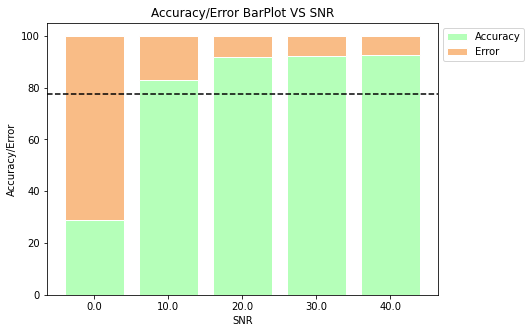

In [ ]:
# Rearrange data for the barPlot
snr = list(accuracyPerSNR.keys())
correct = [i.item() for i in list(accuracyPerSNR.values())]
error = [100 - i for i in correct]

# Parameter of the plot
barWidth = 8
names = ('0.0', '10.0', '20.0', '30.0', '40.0')
plt.figure(figsize=(7, 5)) 

# Plot
plt.bar(snr, correct, color='#b5ffb9', edgecolor='white', width=barWidth, label="Accuracy") # Accuracy
plt.bar(snr, error, bottom=correct, color='#f9bc86', edgecolor='white', width=barWidth, label="Error") # Error
plt.axhline(y = overall_accuracy, color = 'black', linestyle = 'dashed') # Overall accuracy on the validation set

# Custom figure
plt.xticks(snr, names)
plt.xlabel("SNR"); plt.ylabel("Accuracy/Error")
plt.title("Accuracy/Error BarPlot VS SNR")
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.show()

## Observations:

Le modèle présente une accuracy globale de 77.59%.

Pour les SNR de 10, 20, 30 et 40 : l'accuracy est très bonne et dépasse 80% pour chacune de ces SNR.

Pour le SNR=0, on remarque que le modèle a beaucoup de difficultés à détecter la classe du signal si son SNR est 0.

## Conclusion

En conclusion, ce TP m'a permis de prendre en main Pytorch et l'implémentation de réseaux de neurones de type CNN pour la classification de signaux.

Il est nécessaire de prendre une architecture qui permet un embedding correct afin de classifier correctement le signal en couche finale. Le learning rate et optimizer a un fort impact sur les performances du modèle.

Enfin pour améliorer ce modèle, on peut éventuellement essayer un autre type de modèle avec RNN/LSTM. Ou encore proposer un modèle qui classifie le SNR du signal (0 vs 10..40) pour ré-entrainer un modèle indépendant uniquement sur les signaux avec un SNR égale à 0.

# FIN

Merci pour votre lecture ! 

Théo Di Piazza

---